In [1]:
%matplotlib inline


Analysis of a single session, single subject fMRI dataset
=========================================================


From nistats tutorials:
https://nistats.github.io/auto_examples/01_tutorials/plot_single_subject_single_run.html



To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use ``jupyter-notebook``.
    :depth: 1




Retrieving the data
-------------------

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we load the data using a data downloading
          function. To input your own data, you will need to provide
          a list of paths to your own files in the ``subject_data`` variable.
          These should abide to the Brain Imaging Data Structure (BIDS) 
          organization.</p></div>



In [2]:
from nistats.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()
print(subject_data.func)  # print the list of names of functional images


Dataset created in C:\Users\God Y/nilearn_data\spm_auditory

Data absent, downloading...


Downloaded 34212021 of 34212021 bytes (100.0%,    0.0s remaining) ...done. (221 seconds, 3 min)
Extracting data from C:\Users\God Y/nilearn_data\spm_auditory\sub001\MoAEpilot.zip..... done.


['C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_004.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_005.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_006.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_007.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_008.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_009.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_010.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_011.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_012.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_013.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_014.img', 'C:\\Users\\God Y/nilearn_data\\spm_auditory\\sub001\\fM00223/fM00223_015.img', 'C:\\Users\\God Y/nilearn_data\\spm_aud

We can display the first functional image and the subject's anatomy:



In [3]:
%matplotlib inline

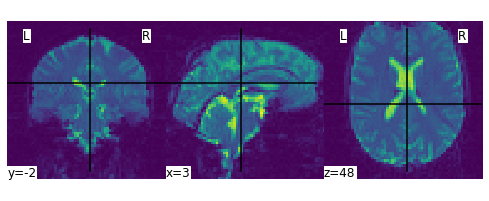

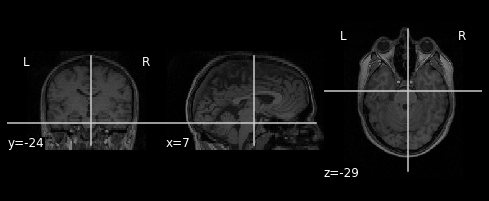

In [4]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
plot_img(subject_data.func[0])
plot_anat(subject_data.anat)

Next, we concatenate all the 3D EPI image into a single 4D image,
then we average them in order to create a background
image that will be used to display the activations:



In [8]:
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

Specifying the experimental paradigm
------------------------------------

We must now provide a description of the experiment, that is, define the
timing of the auditory stimulation and rest periods. This is typically
provided in an events.tsv file. The path of this file is
provided in the dataset.



In [11]:
import pandas as pd
events = pd.read_table(subject_data['events'])
print(events)

    onset  duration trial_type
0     0.0      42.0       rest
1    42.0      42.0     active
2    84.0      42.0       rest
3   126.0      42.0     active
4   168.0      42.0       rest
5   210.0      42.0     active
6   252.0      42.0       rest
7   294.0      42.0     active
8   336.0      42.0       rest
9   378.0      42.0     active
10  420.0      42.0       rest
11  462.0      42.0     active
12  504.0      42.0       rest
13  546.0      42.0     active
14  588.0      42.0       rest
15  630.0      42.0     active


Performing the GLM analysis
---------------------------

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix* using the  information provided by the ``events`` object.



In [12]:
from nistats.first_level_model import FirstLevelModel

D:\ANACONDA\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Parameters of the first-level model

* t_r=7(s) is the time of repetition of acquisitions
* noise_model='ar1' specifies the noise covariance model: a lag-1 dependence
* standardize=False means that we do not want to rescale the time series to mean 0, variance 1
* hrf_model='spm' means that we rely on the SPM "canonical hrf" model (without time or dispersion derivatives)
* drift_model='cosine' means that we model the signal drifts as slow oscillating time functions
* high_pass=0.01(Hz) defines the cutoff frequency (inverse of the time period).Disregard frequency lower than 0.01Hz which is our own stimulation



In [13]:
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

Now that we have specified the model, we can run it on the fMRI image

In [14]:
fmri_glm = fmri_glm.fit(fmri_img, events)

One can inspect the design matrix (rows represent time, and
columns contain the predictors).



In [15]:
design_matrix = fmri_glm.design_matrices_[0]

Formally, we have taken the first design matrix, because the model is
implictily meant to for multiple runs.

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


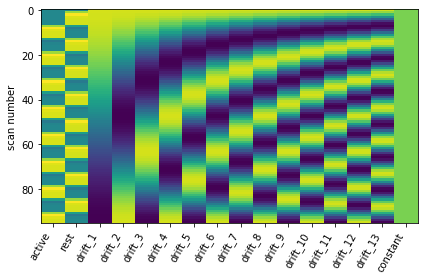

In [16]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Save the design matrix image to disk
first create a directory where you want to write the images



In [17]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

from os.path import join
plot_design_matrix(
    design_matrix, output_file=join(outdir, 'design_matrix.png'))

The first column contains the expected response profile of regions which are
sensitive to the auditory stimulation.
Then plot this first column



D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


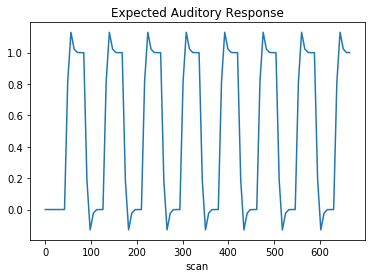

In [18]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

Detecting voxels with significant effects
-----------------------------------------





In [47]:
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0.]),
}

compare the two conditions 'active' and 'rest' by
defining the corresponding contrast:



In [48]:
active_minus_rest = conditions['active'] - conditions['rest']

plot the coefficients of the contrast, indexed by
the names of the columns of the design matrix.



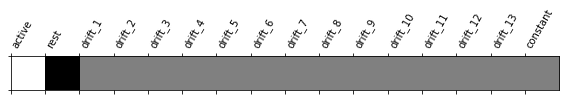

In [49]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [50]:
eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

In order to get statistical significance, it' better to form a t-statistic, and
directly convert is into z-scale. The z-scale means that the values
are scaled to match a standard Gaussian distribution (mean=0,
variance=1), across voxels, if there were now effects in the data.



In [51]:
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

Plot thresholded z scores map.




/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


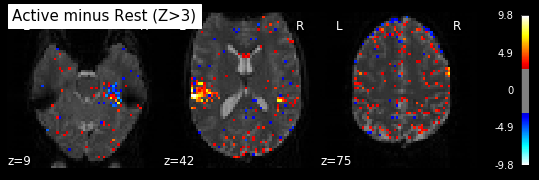

In [19]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)')
plt.show()

Statistical significance testing. One should worry about the
statistical validity of the procedure: here an arbitrary
threshold of 3.0 is used but the threshold should provide some guarantees on
the risk of false detections (aka type-1 errors in statistics).
One suggestion is to control the false positive rate (fpr, denoted by
alpha) at a certain level, e.g. 0.001: this means that there is 0.1% chance
of declaring an inactive voxel, active.



Uncorrected p<0.001 threshold: 3.090


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  import sys


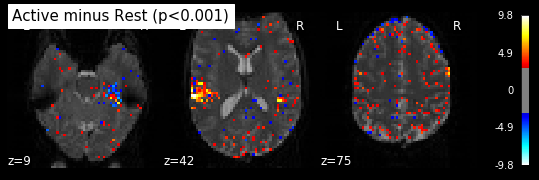

In [20]:
from nistats.thresholding import map_threshold
_, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.001)')
plt.show()

The problem is that with this you expect 0.001 * n_voxels to show up
while they're not active --- tens to hundreds of voxels. A more
conservative solution is to control the family wise error rate,
i.e. the probability of making only one false detection, say at
5%. For that we use the so-called Bonferroni correction



Bonferroni-corrected, p<0.05 threshold: 4.797


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


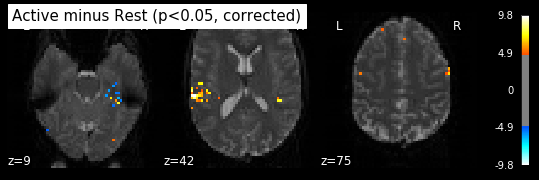

In [21]:
_, threshold = map_threshold(z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (p<0.05, corrected)')
plt.show()

This is quite conservative indeed!  A popular alternative is to
control the expected proportion of
false discoveries among detections. This is called the false
discovery rate



False Discovery rate = 0.05 threshold: 2.760


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


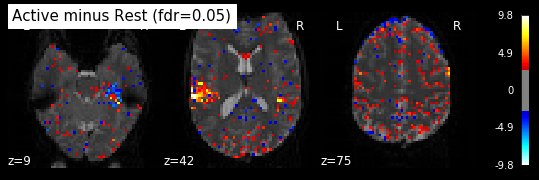

In [22]:
_, threshold = map_threshold(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05)')
plt.show()

Finally people like to discard isolated voxels (aka "small
clusters") from these images. It is possible to generate a
thresholded map with small clusters removed by providing a
cluster_threshold argument. Here clusters smaller than 10 voxels
will be discarded.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


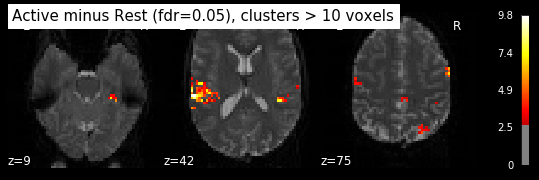

In [23]:
clean_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05), clusters > 10 voxels')
plt.show()

We can save the effect and zscore maps to the disk



In [24]:
z_map.to_filename(join(outdir, 'active_vs_rest_z_map.nii.gz'))
eff_map.to_filename(join(outdir, 'active_vs_rest_eff_map.nii.gz'))

Report the found positions in a table



In [25]:
from nistats.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
print(table)

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -60.0  -6.0  42.0   9.811979               4590
1          1a -63.0   6.0  36.0   8.601922                   
2          1b -63.0   0.0  42.0   8.399054                   
3          1c -48.0 -15.0  39.0   8.364058                   
4           2  60.0   0.0  36.0   9.605128               1728
5          2a  45.0 -12.0  42.0   7.590200                   
6          2b  69.0   6.0  30.0   4.136198                   
7           3  63.0  12.0  27.0   8.284500                999
8          3a  51.0   3.0  30.0   6.968355                   
9          3b  54.0   9.0  39.0   3.565609                   
10          4  36.0  -3.0  15.0   8.087451               1269
11          5  51.0  30.0  27.0   7.850265                756
12         5a  48.0  21.0  27.0   7.411892                   
13         5b  57.0  39.0  27.0   6.043533                   
14         5c  45.0   9.0  27.0   5.133463                   
15      

the table can be saved for future use



In [26]:
table.to_csv(join(outdir, 'table.csv'))

Performing an F-test

"active vs rest" is a typical t test: condition versus
baseline. Another popular type of test is an F test in which one
seeks whether a certain combination of conditions (possibly two-,
three- or higher-dimensional) explains a significant proportion of
the signal.  Here one might for instance test which voxels are well
explained by combination of the active and rest condition.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


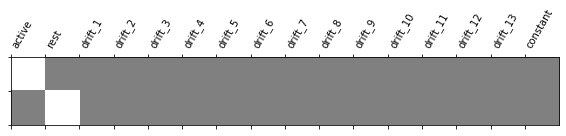

In [27]:
import numpy as np
effects_of_interest = np.vstack((conditions['active'], conditions['rest']))
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

Specify the contrast and compute the corresponding map. Actually, the
contrast specification is done exactly the same way as for t-
contrasts.



In [28]:
z_map = fmri_glm.compute_contrast(effects_of_interest,
                                  output_type='z_score')
plt.show()

Note that the statistic has been converted to a z-variable, which
makes it easier to represent it.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


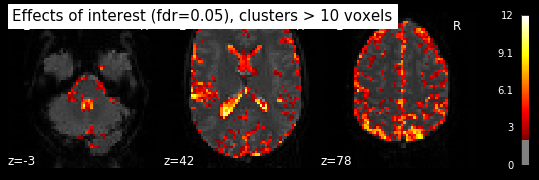

In [29]:
clean_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Effects of interest (fdr=0.05), clusters > 10 voxels')
plt.show()